In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time,os

In [2]:
def show(img):
    plt.imshow(img)
    plt.show()

In [3]:
def hit(arr):
    x = range(1,len(arr)+1)
    y = arr
    plt.plot(x, y)
    plt.show()

In [4]:
#移除边缘
def remove_side(img):
#     show(img)
    image=cv2.adaptiveThreshold(img.copy(),255,cv2.ADAPTIVE_THRESH_MEAN_C ,cv2.THRESH_BINARY_INV,31,30)
    
    image = 255-image
    img_index = np.where(image<150)
    side=3
    if min(img_index[1])-side<0:
        left=min(img_index[1])
    else:
        left = min(img_index[1])-side
    if max(img_index[1])+side>img.shape[1]:
        right = max(img_index[1])
    else:
        right = max(img_index[1])+side
        
    if min(img_index[0])-side<0:
        top=min(img_index[0])
    else:
        top = min(img_index[0])-side
    if max(img_index[0])+side>img.shape[0]:
        bottom = max(img_index[0])
    else:
        bottom = max(img_index[0])+side
        
    img = img[top:bottom,left:right]
    return img

In [5]:
# 得到峰左右index
# 先用阈值得到峰的index群体
# 接着得到峰中间的谷低的index群体

def get_index(arr,th):
    top = np.where(arr>th)[0]
    index_dic = top[1:]-top[:-1]
    top_dic_index = np.where(index_dic>1)[0]
    
    part_right_index = top[top_dic_index]
    right_index = np.zeros(len(part_right_index)+1)
    right_index[-1] = len(arr)
    right_index[:-1] = part_right_index
    right_index = np.int64(right_index+1)
    
    part_left_index = top[top_dic_index]+index_dic[top_dic_index]
    left_index = np.zeros(len(part_left_index)+1)
    left_index[1:] = part_left_index
    left_index = np.int64(left_index)
    
    #得到峰中间的谷低的index群体
    bottom_area = np.zeros(len(part_left_index))
    for num in range(len(part_left_index)):
        area = arr[part_right_index[num]:part_left_index[num]]
        if len(area)>0:
            min_index = np.where(area==np.min(area))[0]+part_right_index[num]
            bottom_area[num] = min_index[int(len(min_index)/2)]
            
#      #得到峰的index群体
#     top_area = np.zeros(len(left_index))
#     for num in range(len(left_index)):
#         area = arr[left_index[num]:right_index[num]]
#         if len(area)>0:
#             max_index = np.where(area==np.max(area))[0]+left_index[num]
#             top_area[num] = max_index[int(len(max_index)/2)]
    return bottom_area

In [6]:
#获取成行图片
def get_row(img):
#     show(img)
    img_mean_y = img.mean(axis=1)
#     hit(img_mean_y)
    bottom_area = get_index(arr = img_mean_y,th =255/60)
    fir_row = np.where(img_mean_y>0)[0]
    side = 10
    if len(fir_row) >0:
        fir_row = np.where(img_mean_y>0)[0][0]
    else:
        fir_row=0
    end_row = np.where(img_mean_y>0)[0]
    if len(end_row) >0:
        end_row = np.where(img_mean_y>0)[0][-1]
    else:
        end_row=len(img_mean_y)-1
    if fir_row >side:
        fir_row-=side
    else:
        fir_row=0
    if len(img_mean_y)-1-end_row>side:
        end_row+=side
    else:
        end_row=len(img_mean_y)-1
    return bottom_area,fir_row,end_row

In [7]:
#获取单行文字
def get_column(img,first_row,second_row):
    img = get_good_img(img[int(first_row):int(second_row),:],300,15,50,15)

#     show(img)
    y = img.mean(axis=0)
#     hit(y)
    bottom_area_x = get_index(y,th = 1)
    fir_column = np.where(y>0)[0]
    side = 10
    if len(fir_column)>0:
        fir_column = np.where(y>0)[0][0]
    else:
        fir_column=0
    end_column = np.where(y>0)[0]
    if len(end_column)>0:
        end_column = np.where(y>0)[0][-1]
    else:
        end_column = len(y)-1
    if fir_column > side:
        fir_column-=side
    else:
        fir_column=0
    if len(y)-1-end_column>side:
        end_column+=side
    else:
        end_column=len(y)-1
    return bottom_area_x,fir_column,end_column

In [8]:
#获取所有行的文字
def get_all_column(good_img,row):
    all_column_area = []
    for idx in range(len(row)-1):
        column_area,fir_column,end_column = get_column(good_img,row[idx],row[idx+1])
        new_column_area = np.zeros(len(column_area)+2)
        new_column_area[0]=fir_column
        new_column_area[1:-1]=column_area
        new_column_area[-1]=end_column
        all_column_area.append(new_column_area)
        
    return all_column_area


In [9]:
#获取文字区域
def get_area(img):
#     show(img_b)
    img_b = get_good_img(img,88,90,20,20)
    '''这里'''
    cv2.imwrite("test.jpg",img_b)
    show(img_b)
    x = np.mean(img_b,axis=1)
    hit(x)
    image, contours, hierarchy = cv2.findContours(img_b.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    min_h = img.shape[0]/2
    min_w = img.shape[1]/3
    areas = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)  # 外接矩形
        if h >min_h and w > min_w :
#             cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
            return x,y,w,h
    

In [10]:
start_ = time.time()
path = "1.jpg"
cut(path)
end_ = time.time()
print(end_-start_)

NameError: name 'cut' is not defined

In [11]:
#图像处理
def get_good_img(img,close_y,close_x,open_y,open_x):#顶帽运算，降低亮度影响，只留单词区域为灰色
    
    name = time.time()
    img=cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C ,cv2.THRESH_BINARY_INV,31,50)
#     img = 255-img
#     #膨胀
#     kernel = np.ones((2,2),np.uint8)#5,5
#     img = cv2.dilate(img,kernel,iterations = 1)
    
        #闭运算
    kernel = np.ones((close_y,close_x),np.uint8)#5,5
    close= cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
    
    #     #开运算
    kernel = np.ones((open_y,open_x),np.uint8)#3,3
    open_img = cv2.morphologyEx(close, cv2.MORPH_OPEN, kernel)
    
    return open_img

In [12]:
def run(img,path):
    
    areas = get_area(img)
    x,y,w,h = areas
    
    img = img[y:y+h,x:x+w]
    good_img = get_good_img(img,20,20,1,1)
#     show(good_img)
    row_area,fir_row,end_row = get_row(good_img)
    new_row_area = np.zeros(len(row_area)+2)
    new_row_area[0]=fir_row
    new_row_area[1:-1]=row_area+3
    new_row_area[-1]=end_row
    all_column_area = get_all_column(img,new_row_area)
    
    words_index = []
    for num in range(1,len(all_column_area)+1):
        word_column = np.zeros((len(all_column_area[num-1])-1,4))
        word_column[:,1] = new_row_area[num-1]
        word_column[:,3] = new_row_area[num]
        word_column[:,0] = all_column_area[num-1][:-1]
        word_column[:,2] = all_column_area[num-1][1:]
        words_index.append(word_column)
    return words_index,areas


In [13]:

def cut(path):
    pic = cv2.imread(path,0)
    plt.rcParams['figure.figsize'] = (30, 15)

    cut_datas,areas = run(pic,path)
    (x,y,w,h) = areas

    c_img = cv2.imread(path,0)
    c_img = c_img[y:y+h,x:x+w]
    
    ii=0
    for cut_data in cut_datas:
        for num in range(len(cut_data)):
            xx = int(round(cut_data[num][2]))
            yy = int(round(cut_data[num][3]))

            x = int(round(cut_data[num][0]))
            y = int(round(cut_data[num][1]))
            tempp = c_img[y:yy, x:xx]
            cv2.imwrite("chinese/"+str(ii)+'.jpg', tempp)
            #tempp = remove_side(tempp)            
            ii+=1
            
#     f.write(str_)
#     f.close()
    

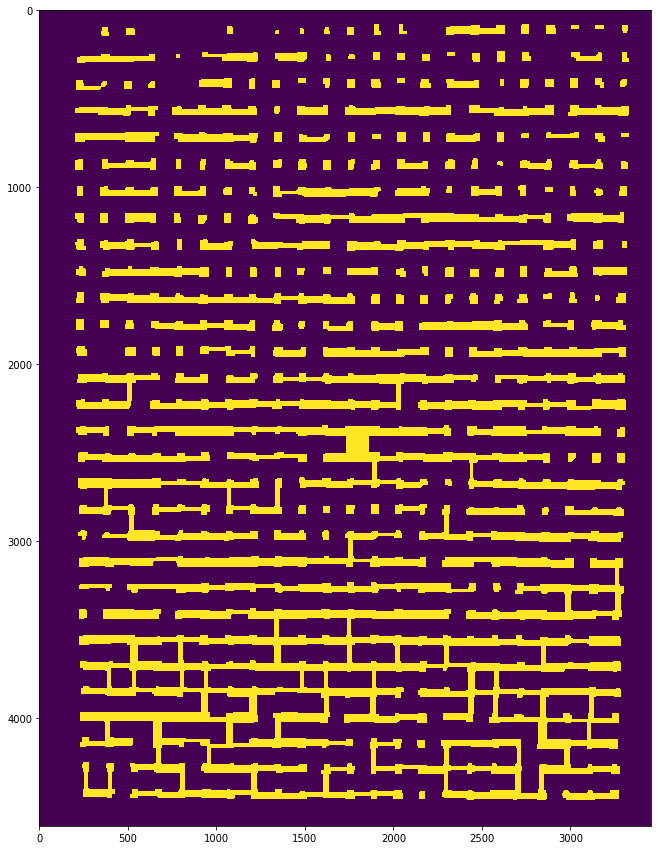

In [7]:
show(img)

array([ 94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106,
       107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
       120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132,
       133, 134, 135, 136, 241, 242, 243, 244, 245, 246, 247, 248, 249,
       250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262,
       263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275,
       276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288,
       289, 290, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399,
       400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412,
       413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425,
       426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438,
       439, 440, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551,
       552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564,
       565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 57

array([  1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1, 105,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,  99,   1,   1,   1,   1,   1,   1,   1], dtype=int64)

array([  42,   92,  144,  198,  251,  306,  360,  416,  470,  523,  580,
        635,  692,  745,  801,  858,  912,  969, 1024, 1079, 1135, 1190,
       1248, 1307, 1366, 1421, 1480, 1537, 1595], dtype=int64)

array([ 136,  290,  440,  594,  744,  899, 1052, 1202, 1354, 1504, 1657,
       1808, 1958, 2107, 2256, 2405, 2552, 2702, 2850, 2996, 3144, 3290,
       3440, 3589, 3734, 3879, 4024, 4168, 4313], dtype=int64)

array([ 241,  389,  541,  692,  845,  999, 1147, 1301, 1452, 1601, 1754,
       1902, 2055, 2201, 2349, 2499, 2646, 2796, 2942, 3089, 3236, 3383,
       3531, 3676, 3825, 3966, 4112, 4256, 4401], dtype=int64)

array([ 188,  339,  490,  643,  794,  949, 1099, 1251, 1403, 1552, 1705,
       1855, 2006, 2154, 2302, 2452, 2599, 2749, 2896, 3042, 3190, 3336,
       3485, 3632, 3779, 3922, 4068, 4212, 4357], dtype=int64)

array([   0,  188,  339,  490,  643,  794,  949, 1099, 1251, 1403, 1552,
       1705, 1855, 2006, 2154, 2302, 2452, 2599, 2749, 2896, 3042, 3190,
       3336, 3485, 3632, 3779, 3922, 4068, 4212, 4357,   -1])

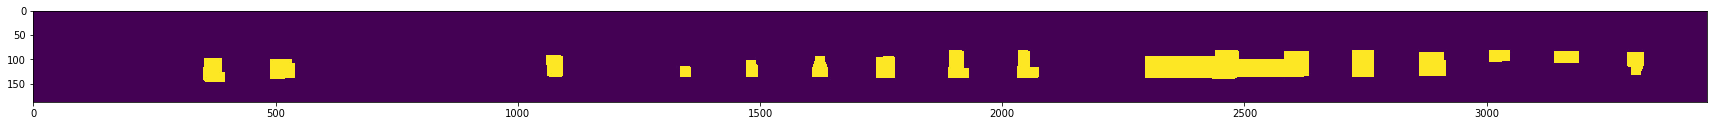

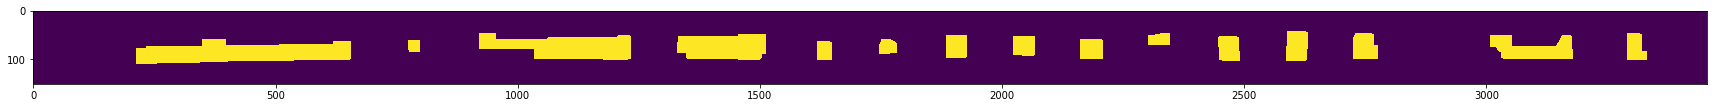

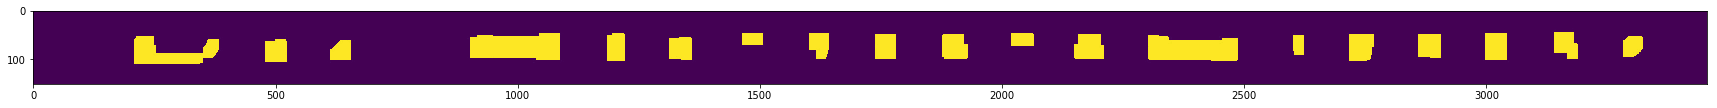

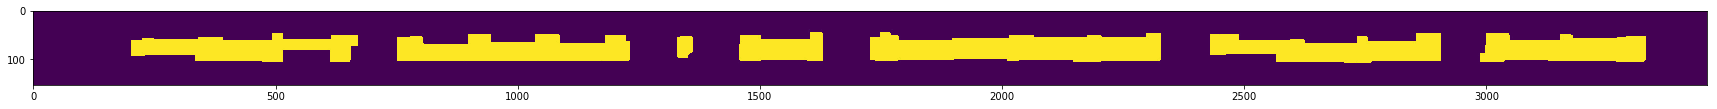

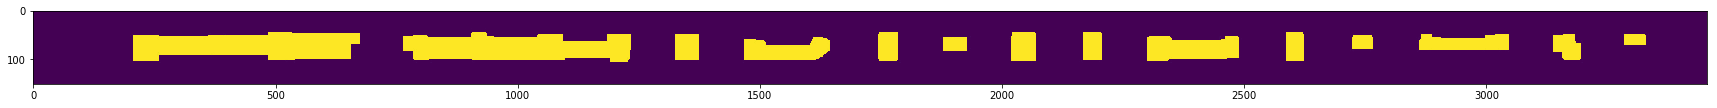

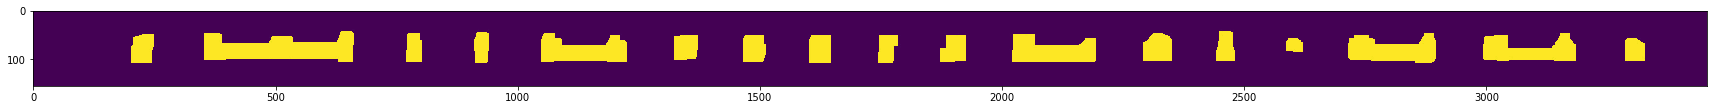

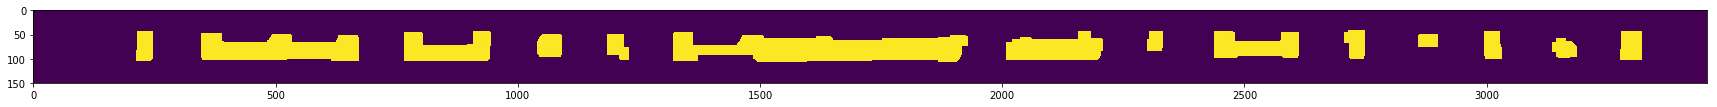

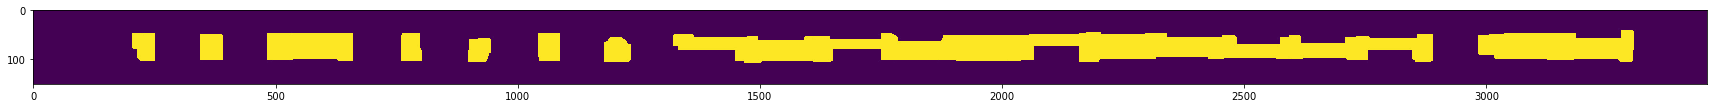

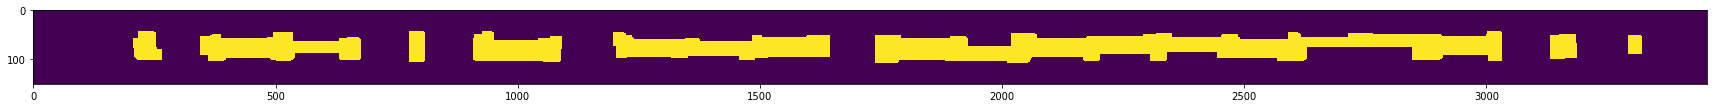

KeyboardInterrupt: 

<Figure size 2160x1080 with 0 Axes>

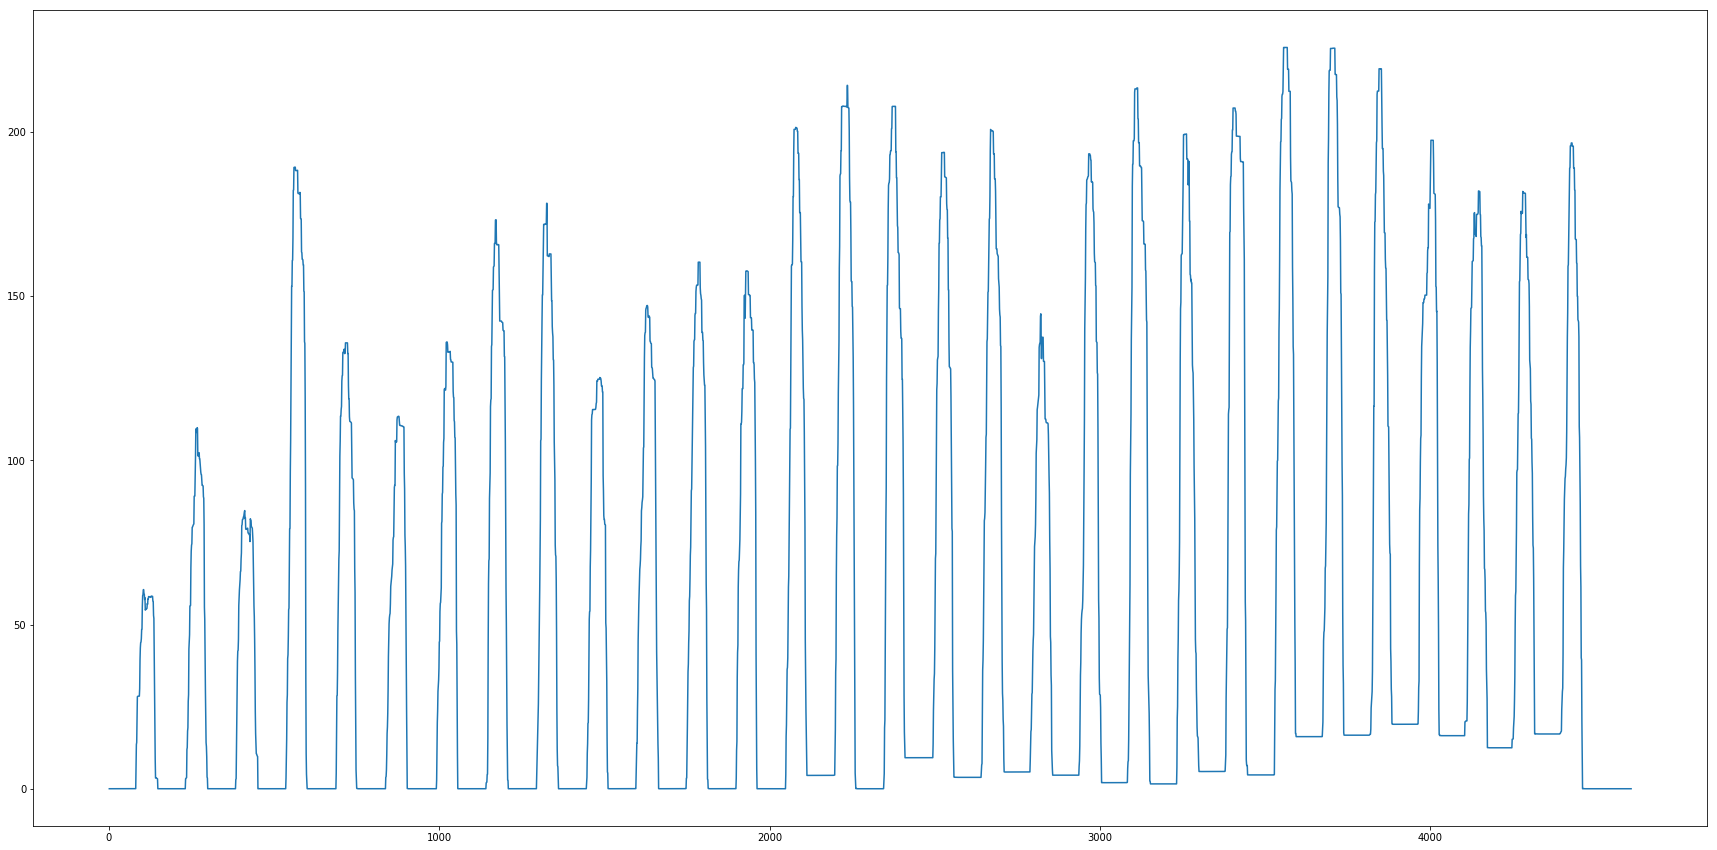

In [12]:
hit(y)